In [1]:
import pandas as pd
import numpy as np 

from pyhhmm.gaussian import GaussianHMM

import yfinance as yf

import matplotlib.pyplot as plt

# Data Management

In [2]:
# Data Extraction
start_date = "2020-01-01"
end_date = "2023-05-29"
symbol = "SPY"

# USE YAHOO FINANCE 
data = yf.download(symbol ,  start_date , end_date )
data = data[["Open" , "High" , "Low" , "Close" , "Volume"]]

[*********************100%***********************]  1 of 1 completed


In [3]:
# Add Returns and Range    
# Returns = (todays price divided by yesterdays)     # ROI since Yesterday
# Range   = (todays high price divided todays low)   # volitility from highest point to lowest within day

df = data.copy()
df["Returns"] = (df["Close"] / df["Close"].shift(1)) - 1
df["Range"]   = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)

df


,Open,High,Low,Close,Volume,Returns,Range
Date,,,,,,,
2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700,-0.007572,0.007910
2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900,0.003815,0.010519
2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400,-0.002812,0.004034
2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000,0.005330,0.009638
2020-01-09,326.160004,326.730011,325.519989,326.649994,48473300,0.006781,0.003717
...,...,...,...,...,...,...,...
2023-05-22,418.640015,420.390015,417.350006,418.790009,60745400,0.000406,0.007284
2023-05-23,417.079987,418.720001,413.679993,414.089996,86383500,-0.011223,0.012183
2023-05-24,412.420013,412.820007,409.880005,411.089996,89213700,-0.007245,0.007173


# HMM - Hidden States
- HMM is a model that looks for hidden states in the market
- states
    -  (upward) , (downward) , (sidways), and many more

In [4]:
# Structure Data (create a new dataframe using the returns and range)
x_train = df[[ "Returns" , "Range" ]]
x_train

,Returns,Range
Date,,
2020-01-03,-0.007572,0.007910
2020-01-06,0.003815,0.010519
2020-01-07,-0.002812,0.004034
2020-01-08,0.005330,0.009638
2020-01-09,0.006781,0.003717
...,...,...
2023-05-22,0.000406,0.007284
2023-05-23,-0.011223,0.012183
2023-05-24,-0.007245,0.007173


# HMM - Learning & Output
- Covarience Types
    - <b>Full</b> means the components may independently adopt any position and shape.

    - <b>Tied</b> means they have the same shape, but the shape may be anything.

    - <b>Diagonal</b> means the contour axes are oriented along the coordinate axes, but otherwise the eccentricities may vary between components.

    - <b>Tied Diagonal</b> is a "tied" situation where the contour axes are oriented along the coordinate axes. (I have added this because initially it was how I misinterpreted "diagonal.")

    - <b>Spherical</b> is a "diagonal" situation with circular contours (spherical in higher dimensions, whence the name).

In [5]:
# Train Model
model = GaussianHMM(n_states=4, covariance_type="full" , n_emissions=2)
model.train([np.array(x_train.values)])

model.__dir__()

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


['n_states',
 'tr_params',
 'init_params',
 'init_type',
 'pi_prior',
 'A_prior',
 'learning_rate',
 'verbose',
 'n_emissions',
 'covariance_type',
 'means_prior',
 'means_weight',
 'covars_prior',
 'covars_weight',
 'min_covar',
 'pi',
 'A',
 'means',
 '_covars',
 '__module__',
 '__doc__',
 '__init__',
 '__str__',
 'covars',
 'get_n_fit_scalars_per_param',
 '_init_model_params',
 '_initialise_sufficient_statistics',
 '_accumulate_sufficient_statistics',
 '_reestimate_stat_obs',
 '_reestimate_stat_obs2',
 '_infer_missing',
 '_M_step',
 '_update_model',
 '_map_B',
 '_calc_conditional_posterior',
 '_calc_sigma',
 '_pdf',
 '_generate_sample_from_state',
 'forward',
 'score',
 'score_samples',
 'predict',
 'predict_proba',
 'decode',
 'train',
 'sample',
 'get_stationary_distribution',
 '_decode_map',
 '_decode_viterbi',
 '_calc_alpha',
 '_calc_beta',
 '_calc_xi',
 '_calc_gamma',
 '_train',
 '_compute_intermediate_values',
 '_E_step',
 '_sum_up_sufficient_statistics',
 '__dict__',
 '__weak

In [6]:
# Check State Categorization
hidden_states = model.predict([x_train.values])[0]
hidden_states

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 3, 0, 3, 2, 0, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       1, 1, 1, 0, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2,
       2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 3, 3, 0, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2,

In [7]:
# State Result Means for Each State 
print(f"[Returns avg , Range avg ]")
model.means

[Returns avg , Range avg ]


array([[ 0.004575  ,  0.01403623],
       [-0.00369539,  0.0479958 ],
       [ 0.00416812,  0.01062233],
       [-0.00847504,  0.01984181]])

In [8]:
# State Result Covariations for Each State 
print(f"[Returns avg , Range avg ]")
model.covars

[Returns avg , Range avg ]


array([[[2.21714852e-04, 1.38546066e-04],
        [1.38546066e-04, 1.51499189e-04]],

       [[2.46608554e-03, 2.38201895e-04],
        [2.38201895e-04, 6.12561741e-04]],

       [[8.30555758e-05, 3.87959690e-05],
        [3.87959690e-05, 4.73336119e-05]],

       [[2.11430604e-04, 1.01701511e-05],
        [1.01701511e-05, 1.16889022e-04]]])

# Data Visualization

In [9]:
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []


prices = df["Close"].values.astype(float)


print("Check pass length of Close matches Hidden states array: " , len(prices)  ==  len(hidden_states)  )


for s in range(0,len(hidden_states), 1):
    if hidden_states[s] == 0:
        labels_0.append(prices[s])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    elif hidden_states[s]  == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[s])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    elif hidden_states[s]  == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[s])
        labels_3.append(float('nan'))
    elif hidden_states[s]  == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[s])


labels_0

Check pass length of Close matches Hidden states array:  True


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 278.20001220703125,
 nan,
 283.7900085449219,
 nan,
 nan,
 286.6400146484375,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 295.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 312.9599914550781,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,

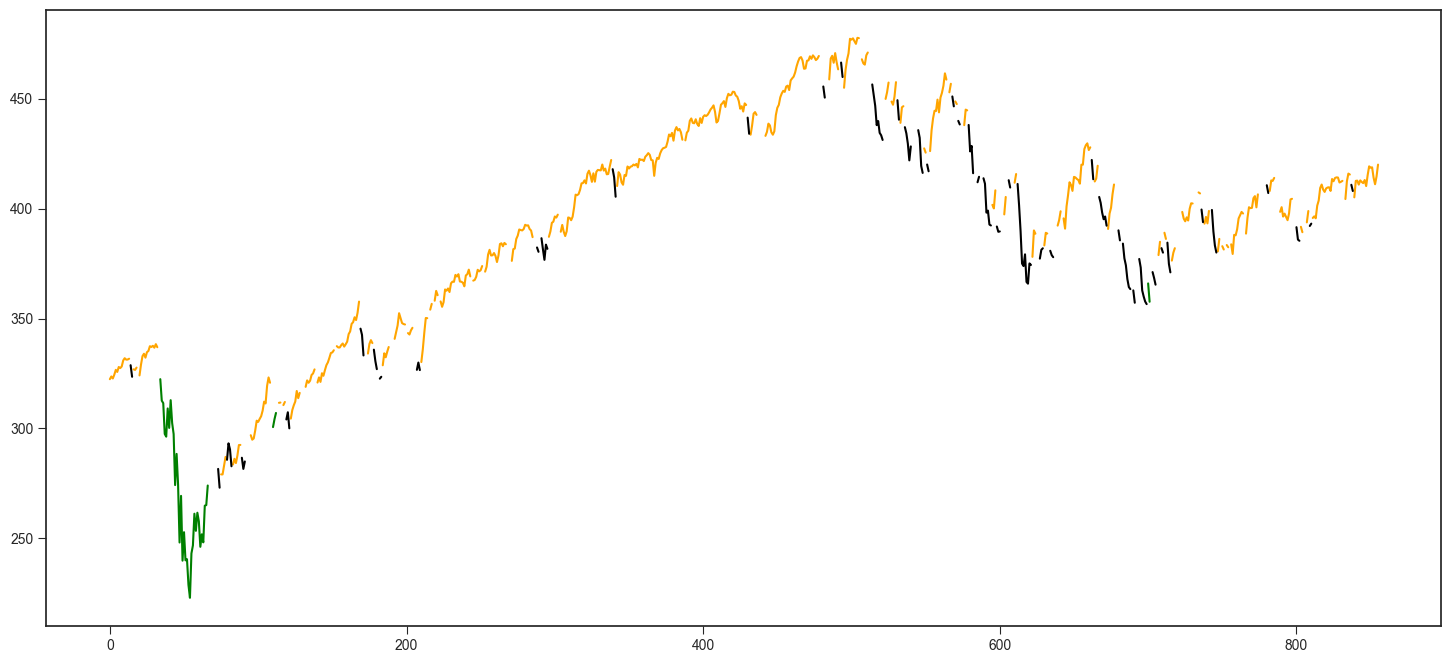

In [10]:
# Plot Chart
figure = plt.figure(figsize=(18,8))

plt.plot(labels_0,color="red")
plt.plot(labels_1,color="green")
plt.plot(labels_2,color="orange")
plt.plot(labels_3,color="black")
plt.show()